In [236]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'c:\\Users\\Joaquín Amat\\Documents\\GitHub\\skforecast'

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set theme for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.preprocessing import TimeSeriesDifferentiator
from skforecast.model_selection import backtesting_forecaster

# Data

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


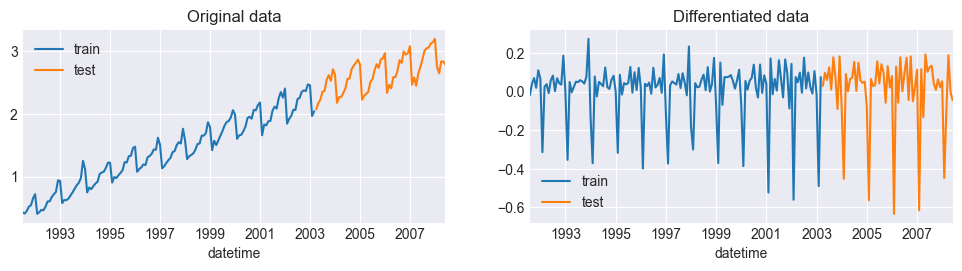

In [238]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data differentiated
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data)
data_diff = pd.Series(data_diff, index=data.index).dropna()

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(12, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

# Compare regressors

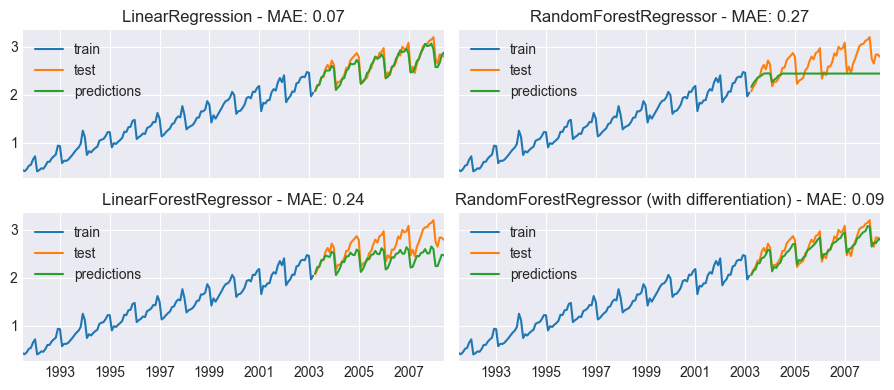

In [239]:
# Compare predictions of different models
# ==============================================================================
regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=963),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]
steps = len(data.loc[end_train:])

fig, ax = plt.subplots(2, 2, figsize=(9, 4), sharex=True, sharey=True)
ax = ax.ravel()
# ForecasterAutoreg
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=15
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=steps)
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'{forecaster.regressor.__class__.__name__} - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoreg with random forest regressor and differentiation
forecaster = ForecasterAutoreg(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=steps)
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'{forecaster.regressor.__class__.__name__} (with differentiation) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

# Validation: differentiation before training or during the training

## Predict

Series differentiated before training
-------------------------------------
Last window of training series: datetime
2002-01-01    0.143554
2002-02-01   -0.560283
2002-03-01    0.075580
2002-04-01    0.048697
2002-05-01    0.098076
2002-06-01   -0.005842
2002-07-01    0.175968
2002-08-01    0.016304
2002-09-01    0.098830
2002-10-01    0.023778
2002-11-01   -0.010180
2002-12-01    0.105980
2003-01-01   -0.014631
2003-02-01   -0.489849
2003-03-01    0.075037
Freq: MS, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253,-0.018889
1992-12-01,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253
1993-01-01,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384


Predictions


2003-04-01    0.017092
2003-05-01    0.085509
2003-06-01    0.030617
2003-07-01    0.127380
2003-08-01    0.001914
                ...   
2008-02-01   -0.419348
2008-03-01    0.081277
2008-04-01   -0.008556
2008-05-01    0.062505
2008-06-01    0.032060
Freq: MS, Name: pred, Length: 63, dtype: float64

2003-04-01    2.060425
2003-05-01    2.145934
2003-06-01    2.176551
2003-07-01    2.303930
2003-08-01    2.305844
                ...   
2008-02-01    2.651466
2008-03-01    2.732743
2008-04-01    2.724187
2008-05-01    2.786692
2008-06-01    2.818752
Length: 63, dtype: float64


Series differentiated during training
-------------------------------------
Last window of training series: datetime
2001-12-01    2.262313
2002-01-01    2.405868
2002-02-01    1.845584
2002-03-01    1.921165
2002-04-01    1.969862
2002-05-01    2.067938
2002-06-01    2.062096
2002-07-01    2.238064
2002-08-01    2.254368
2002-09-01    2.353198
2002-10-01    2.376976
2002-11-01    2.366796
2002-12-01    2.472776
2003-01-01    2.458145
2003-02-01    1.968296
2003-03-01    2.043333
Freq: MS, Name: y, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253,-0.018889
1992-12-01,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253
1993-01-01,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384


Predictions


2003-04-01    2.060425
2003-05-01    2.145934
2003-06-01    2.176551
2003-07-01    2.303930
2003-08-01    2.305844
                ...   
2008-02-01    2.651466
2008-03-01    2.732743
2008-04-01    2.724187
2008-05-01    2.786692
2008-06-01    2.818752
Freq: MS, Name: pred, Length: 63, dtype: float64

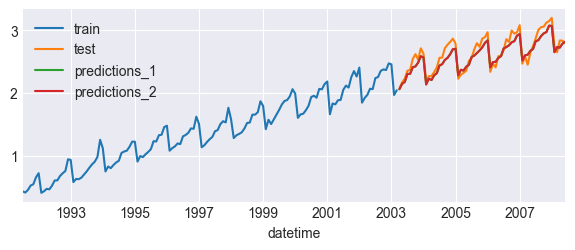

In [240]:
# Comparasion of results if the time series is differentiated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
last_window_1 = forecaster_1.last_window
print(f"Last window of training series: {last_window_1}")
print("Train matrix")
X_train_1, y_train_1 = forecaster_1.create_train_X_y(data_diff.loc[:end_train])
display(X_train_1.head(3))
predictions_diff = forecaster_1.predict(steps=steps)
last_value_train = data.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
print("Predictions")
display(predictions_diff)
display(predictions_1)
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1
             )

forecaster_2.fit(y=data.loc[:end_train])
last_window_2 = forecaster_2.last_window
print(f"Last window of training series: {last_window_2}")
print("Train matrix")
X_train_2, y_train_2 = forecaster_2.create_train_X_y(data.loc[:end_train])
display(X_train_2.head(3))
predictions_2 = forecaster_2.predict(steps=steps)
print("Predictions")
display(predictions_2)

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label='predictions_1')
predictions_2.plot(ax=ax, label='predictions_2')
ax.legend();


In [241]:
pd.testing.assert_frame_equal(X_train_1, X_train_2, check_names=True)
pd.testing.assert_frame_equal(forecaster_1.get_feature_importances(), forecaster_2.get_feature_importances(), check_names=True)
pd.testing.assert_series_equal(predictions_1.asfreq('MS'), predictions_2, check_names=False)

## Bootstrapping

In [242]:
# Compare bootstrapping prediction if the time series is differenciated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
boot_predictions_diff = forecaster_1.predict_bootstrapping(
                            steps=steps,
                            n_boot=10
                        )
last_value_train = data.loc[:end_train].iloc[[-1]]

boot_predictions_1 = boot_predictions_diff.copy()
boot_predictions_1.loc[last_value_train.index[0]] = last_value_train.values[0]
boot_predictions_1 = boot_predictions_1.sort_index()
boot_predictions_1 = boot_predictions_1.cumsum(axis=0).iloc[1:,]
boot_predictions_1 = boot_predictions_1.asfreq('MS')

print("Predictions")
display(boot_predictions_diff.head(3))
print("Predictions undifferentiated")
display(boot_predictions_1.head(3))
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1
               )

forecaster_2.fit(y=data.loc[:end_train])
boot_predictions_2 = forecaster_2.predict_bootstrapping(
                        steps=steps,
                        n_boot=10
                     )
print("Predictions")
display(boot_predictions_2.head(3))

Series differentiated before training
-------------------------------------
Predictions


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2003-04-01,0.030295,0.032775,-0.002842,0.014901,0.043229,0.001341,0.001325,0.010020,0.040975,0.019096
2003-05-01,0.060069,0.053095,0.082596,0.083665,0.070504,0.086381,0.066698,0.084330,0.087346,0.109301
2003-06-01,0.046608,0.036182,0.037772,0.054342,0.025494,0.037961,0.060449,0.040089,0.022522,0.021476


Predictions undifferentiated


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2003-04-01,2.073628,2.076108,2.040491,2.058234,2.086562,2.044674,2.044659,2.053353,2.084308,2.062429
2003-05-01,2.133696,2.129204,2.123086,2.141899,2.157067,2.131055,2.111357,2.137683,2.171655,2.171730
2003-06-01,2.180305,2.165386,2.160859,2.196241,2.182561,2.169016,2.171806,2.177772,2.194176,2.193207



Series differentiated during training
-------------------------------------
Predictions


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2003-04-01,2.073628,2.076108,2.040491,2.058234,2.086562,2.044674,2.044659,2.053353,2.084308,2.062429
2003-05-01,2.133696,2.129204,2.123086,2.141899,2.157067,2.131055,2.111357,2.137683,2.171655,2.171730
2003-06-01,2.180305,2.165386,2.160859,2.196241,2.182561,2.169016,2.171806,2.177772,2.194176,2.193207


In [243]:
pd.testing.assert_frame_equal(boot_predictions_1, boot_predictions_2)

## Backtesting

In [235]:
last_value_train = data.loc[:end_train].iloc[[-1]]
last_value_train

datetime
2003-03-01    2.043333
Name: y, dtype: float64

In [251]:
# Backtesting
# ==============================================================================
steps = 10
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )
_, predictions_diff = backtesting_forecaster(
                          forecaster            = forecaster_1,
                          y                     = data_diff,
                          steps                 = steps,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_diff.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )
predictions_diff = predictions_diff['pred']
last_value_train = data.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 140
Number of observations used for backtesting: 63
    Number of folds: 7
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   1991-08-01 00:00:00 -- 2003-03-01 00:00:00  (n=140)
    Validation: 2003-04-01 00:00:00 -- 2004-01-01 00:00:00  (n=10)
Fold: 1
    Training:   1991-08-01 00:00:00 -- 2004-01-01 00:00:00  (n=150)
    Validation: 2004-02-01 00:00:00 -- 2004-11-01 00:00:00  (n=10)
Fold: 2
    Training:   1991-08-01 00:00:00 -- 2004-11-01 00:00:00  (n=160)
    Validation: 2004-12-01 00:00:00 -- 2005-09-01 00:00:00  (n=10)
Fold: 3
    Training:   1991-08-01 00:00:00 -- 2005-09-01 00:00:00  (n=170)
    Validation: 2005-10-01 00:00:00 -- 2006-07-01 00:00:00  (n=10)
Fold: 4
    Training:   1991-08-01 00:00:00 -- 2006-07-01 00:00:00  (n=1

  0%|          | 0/7 [00:00<?, ?it/s]

172.43651298010008

In [246]:

forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation=1
             )
_, predictions_2 = backtesting_forecaster(
                          forecaster            = forecaster_2,
                          y                     = data,
                          steps                 = steps,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )
predictions_2 = predictions_2['pred']

predictions_1 = predictions_1.asfreq(predictions_2.index.freq)
predictions_1.name = predictions_2.name


results = pd.concat((predictions_1, predictions_2), axis=1)
results.columns = ['pred_1', 'pred_2']
results['equal'] = np.isclose(results['pred_1'], results['pred_2'])
# add column with the row number
results['step'] = results.reset_index().index + 1
results.head(15)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 140
    Number of observations used for differentiation: 1
Number of observations used for backtesting: 63
    Number of folds: 7
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   1991-08-01 00:00:00 -- 2003-04-01 00:00:00  (n=140)
    Validation: 2003-04-01 00:00:00 -- 2004-01-01 00:00:00  (n=10)
Fold: 1
    Training:   1991-08-01 00:00:00 -- 2004-02-01 00:00:00  (n=150)
    Validation: 2004-02-01 00:00:00 -- 2004-11-01 00:00:00  (n=10)
Fold: 2
    Training:   1991-08-01 00:00:00 -- 2004-12-01 00:00:00  (n=160)
    Validation: 2004-12-01 00:00:00 -- 2005-09-01 00:00:00  (n=10)
Fold: 3
    Training:   1991-08-01 00:00:00 -- 2005-10-01 00:00:00  (n=170)
    Validation: 2005-10-01 00:00:00 -- 2006-07-01 00:00:00  (n=10)
Fold: 4
    Train

  0%|          | 0/7 [00:00<?, ?it/s]

,pred_1,pred_2,equal,step
2003-04-01,2.060425,2.060425,True,1
2003-05-01,2.145934,2.145934,True,2
2003-06-01,2.176551,2.176551,True,3
2003-07-01,2.303930,2.303930,True,4
2003-08-01,2.305844,2.305844,True,5
2003-09-01,2.410863,2.410863,True,6
2003-10-01,2.424657,2.424657,True,7
2003-11-01,2.484868,2.484868,True,8
2003-12-01,2.586600,2.586600,True,9
2004-01-01,2.567780,2.567780,True,10


!!!! El problema está en la desdiferenciación!!!!!

In [247]:
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1
             )

forecaster_1.fit(y=data.loc[:"2004-01-01"])
predictions = forecaster_1.predict(steps=steps)
predictions

2004-02-01    2.208546
2004-03-01    2.292694
2004-04-01    2.282659
2004-05-01    2.395014
2004-06-01    2.430126
2004-07-01    2.531730
2004-08-01    2.557890
2004-09-01    2.700439
2004-10-01    2.725680
2004-11-01    2.745001
Freq: MS, Name: pred, dtype: float64

In [248]:
forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
             )

forecaster_2.fit(y=data_diff.loc[:"2004-01-01"])
predictions_diff = forecaster_2.predict(steps=steps)
predictions_diff

2004-02-01   -0.421580
2004-03-01    0.084149
2004-04-01   -0.010036
2004-05-01    0.112356
2004-06-01    0.035112
2004-07-01    0.101604
2004-08-01    0.026161
2004-09-01    0.142549
2004-10-01    0.025241
2004-11-01    0.019321
Freq: MS, Name: pred, dtype: float64

In [249]:
predictions_diff.iloc[0] = predictions_diff.iloc[0] + data.loc[:"2004-01-01"][-1]
predictions_diff.cumsum()

2004-02-01    2.208546
2004-03-01    2.292694
2004-04-01    2.282659
2004-05-01    2.395014
2004-06-01    2.430126
2004-07-01    2.531730
2004-08-01    2.557890
2004-09-01    2.700439
2004-10-01    2.725680
2004-11-01    2.745001
Freq: MS, Name: pred, dtype: float64

In [51]:
from skforecast.model_selection import _create_backtesting_folds

folds_1 = _create_backtesting_folds(
    data = data_diff,
    window_size = forecaster_1.window_size,
    initial_train_size = len(data_diff.loc[:end_train]),
    test_size = steps,
    externally_fitted =False,
    refit = True,
    fixed_train_size = True,
    gap =0,
    allow_incomplete_fold =True,
    return_all_indexes =False,
    differentiation = forecaster_1.differentiation,
    verbose =True
)

folds_2 = _create_backtesting_folds(
    data = data,
    window_size = forecaster_2.window_size,
    initial_train_size = len(data.loc[:end_train]),
    test_size = steps,
    externally_fitted =False,
    refit = True,
    fixed_train_size = True,
    gap =0,
    allow_incomplete_fold =True,
    return_all_indexes =False,
    differentiation = forecaster_2.differentiation,
    verbose =True
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 140
Number of observations used for backtesting: 63
    Number of folds: 7
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   1991-08-01 00:00:00 -- 2003-03-01 00:00:00  (n=140)
    Validation: 2003-04-01 00:00:00 -- 2004-01-01 00:00:00  (n=10)
Fold: 1
    Training:   1992-06-01 00:00:00 -- 2004-01-01 00:00:00  (n=140)
    Validation: 2004-02-01 00:00:00 -- 2004-11-01 00:00:00  (n=10)
Fold: 2
    Training:   1993-04-01 00:00:00 -- 2004-11-01 00:00:00  (n=140)
    Validation: 2004-12-01 00:00:00 -- 2005-09-01 00:00:00  (n=10)
Fold: 3
    Training:   1994-02-01 00:00:00 -- 2005-09-01 00:00:00  (n=140)
    Validation: 2005-10-01 00:00:00 -- 2006-07-01 00:00:00  (n=10)
Fold: 4
    Training:   1994-12-01 00:00:00 -- 2006-07-01 00:00:00  (n=1

In [49]:
for i in range(len(folds_1)):
    print('Fold: ', i)
    print(folds_1[i])
    print(folds_2[i])
    print("")

Fold:  0
[[0, 140], [125, 140], [140, 152], [140, 152], False]
[[0, 141], [125, 141], [141, 153], [141, 153], False]

Fold:  1
[[12, 152], [137, 152], [152, 164], [152, 164], True]
[[12, 153], [137, 153], [153, 165], [153, 165], True]

Fold:  2
[[24, 164], [149, 164], [164, 176], [164, 176], True]
[[24, 165], [149, 165], [165, 177], [165, 177], True]

Fold:  3
[[36, 176], [161, 176], [176, 188], [176, 188], True]
[[36, 177], [161, 177], [177, 189], [177, 189], True]

Fold:  4
[[48, 188], [173, 188], [188, 200], [188, 200], True]
[[48, 189], [173, 189], [189, 201], [189, 201], True]

Fold:  5
[[60, 200], [185, 200], [200, 203], [200, 203], True]
[[60, 201], [185, 201], [201, 204], [201, 204], True]



In [53]:
for i in range(len(folds_1)):
    print('Fold: ', i)
    print("  Train")
    print(data_diff.index[folds_1[i][0]].astype(str).tolist())
    print(data.index[folds_2[i][0]].astype(str).tolist())
    print("  Last window")
    print(data_diff.index[folds_1[i][1]].astype(str).tolist())
    print(data.index[folds_2[i][1]].astype(str).tolist())
    print("  Test including the gap")
    print(data_diff.index[folds_1[i][2]].astype(str).tolist())
    print(data.index[folds_2[i][2]].astype(str).tolist())
    print("  Test excluding the gap")
    print(data_diff.index[folds_1[i][3]].astype(str).tolist())
    print(data.index[folds_2[i][3]].astype(str).tolist())
    print("")

Fold:  0
  Train
['1991-08-01', '2003-04-01']
['1991-07-01', '2003-04-01']
  Last window
['2002-01-01', '2003-04-01']
['2001-12-01', '2003-04-01']
  Test including the gap
['2003-04-01', '2004-02-01']
['2003-04-01', '2004-02-01']
  Test excluding the gap
['2003-04-01', '2004-02-01']
['2003-04-01', '2004-02-01']

Fold:  1
  Train
['1992-06-01', '2004-02-01']
['1992-05-01', '2004-02-01']
  Last window
['2002-11-01', '2004-02-01']
['2002-10-01', '2004-02-01']
  Test including the gap
['2004-02-01', '2004-12-01']
['2004-02-01', '2004-12-01']
  Test excluding the gap
['2004-02-01', '2004-12-01']
['2004-02-01', '2004-12-01']

Fold:  2
  Train
['1993-04-01', '2004-12-01']
['1993-03-01', '2004-12-01']
  Last window
['2003-09-01', '2004-12-01']
['2003-08-01', '2004-12-01']
  Test including the gap
['2004-12-01', '2005-10-01']
['2004-12-01', '2005-10-01']
  Test excluding the gap
['2004-12-01', '2005-10-01']
['2004-12-01', '2005-10-01']

Fold:  3
  Train
['1994-02-01', '2005-10-01']
['1994-01-01

IndexError: index 203 is out of bounds for axis 0 with size 203

In [33]:
print(folds_2)
for fold in folds_2:
    print([data.index[fold[0]],data.index[fold[1]], data.index[fold[2]]])

[[[0, 141], [125, 141], [141, 153], [141, 153], False], [[0, 141], [137, 153], [153, 165], [153, 165], False], [[0, 141], [149, 165], [165, 177], [165, 177], False], [[0, 141], [161, 177], [177, 189], [177, 189], False], [[0, 141], [173, 189], [189, 201], [189, 201], False], [[0, 141], [185, 201], [201, 204], [201, 204], False]]
[DatetimeIndex(['1991-07-01', '2003-04-01'], dtype='datetime64[ns]', name='datetime', freq=None), DatetimeIndex(['2001-12-01', '2003-04-01'], dtype='datetime64[ns]', name='datetime', freq=None), DatetimeIndex(['2003-04-01', '2004-04-01'], dtype='datetime64[ns]', name='datetime', freq=None)]
[DatetimeIndex(['1991-07-01', '2003-04-01'], dtype='datetime64[ns]', name='datetime', freq=None), DatetimeIndex(['2002-12-01', '2004-04-01'], dtype='datetime64[ns]', name='datetime', freq=None), DatetimeIndex(['2004-04-01', '2005-04-01'], dtype='datetime64[ns]', name='datetime', freq=None)]
[DatetimeIndex(['1991-07-01', '2003-04-01'], dtype='datetime64[ns]', name='datetime',

IndexError: index 204 is out of bounds for axis 0 with size 204

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

Las predicciones dejan de ser reproducibles a partir del primer fold

</div>

In [ ]:
pd.testing.assert_series_equal(predictions_1, predictions_2)

AssertionError: Series are different

Series values are different (92.06349 %)
[index]: [2003-04-01T00:00:00.000000000, 2003-05-01T00:00:00.000000000, 2003-06-01T00:00:00.000000000, 2003-07-01T00:00:00.000000000, 2003-08-01T00:00:00.000000000, 2003-09-01T00:00:00.000000000, 2003-10-01T00:00:00.000000000, 2003-11-01T00:00:00.000000000, 2003-12-01T00:00:00.000000000, 2004-01-01T00:00:00.000000000, 2004-02-01T00:00:00.000000000, 2004-03-01T00:00:00.000000000, 2004-04-01T00:00:00.000000000, 2004-05-01T00:00:00.000000000, 2004-06-01T00:00:00.000000000, 2004-07-01T00:00:00.000000000, 2004-08-01T00:00:00.000000000, 2004-09-01T00:00:00.000000000, 2004-10-01T00:00:00.000000000, 2004-11-01T00:00:00.000000000, 2004-12-01T00:00:00.000000000, 2005-01-01T00:00:00.000000000, 2005-02-01T00:00:00.000000000, 2005-03-01T00:00:00.000000000, 2005-04-01T00:00:00.000000000, 2005-05-01T00:00:00.000000000, 2005-06-01T00:00:00.000000000, 2005-07-01T00:00:00.000000000, 2005-08-01T00:00:00.000000000, 2005-09-01T00:00:00.000000000, 2005-10-01T00:00:00.000000000, 2005-11-01T00:00:00.000000000, 2005-12-01T00:00:00.000000000, 2006-01-01T00:00:00.000000000, 2006-02-01T00:00:00.000000000, 2006-03-01T00:00:00.000000000, 2006-04-01T00:00:00.000000000, 2006-05-01T00:00:00.000000000, 2006-06-01T00:00:00.000000000, 2006-07-01T00:00:00.000000000, 2006-08-01T00:00:00.000000000, 2006-09-01T00:00:00.000000000, 2006-10-01T00:00:00.000000000, 2006-11-01T00:00:00.000000000, 2006-12-01T00:00:00.000000000, 2007-01-01T00:00:00.000000000, 2007-02-01T00:00:00.000000000, 2007-03-01T00:00:00.000000000, 2007-04-01T00:00:00.000000000, 2007-05-01T00:00:00.000000000, 2007-06-01T00:00:00.000000000, 2007-07-01T00:00:00.000000000, 2007-08-01T00:00:00.000000000, 2007-09-01T00:00:00.000000000, 2007-10-01T00:00:00.000000000, 2007-11-01T00:00:00.000000000, 2007-12-01T00:00:00.000000000, 2008-01-01T00:00:00.000000000, 2008-02-01T00:00:00.000000000, 2008-03-01T00:00:00.000000000, 2008-04-01T00:00:00.000000000, 2008-05-01T00:00:00.000000000, 2008-06-01T00:00:00.000000000]
[left]:  [2.0604254780000004, 2.1459342936000003, 2.1765508763000003, 2.3039304083000003, 2.3058439309000005, 2.4102680976000004, 2.4156868792000004, 2.4602899558000004, 2.5652948831000004, 2.5294921769000003, 2.1079126076000003, 2.1920612086, 2.1820254917, 2.2943809918, 2.3294930605000004, 2.450323066, 2.4718057145000003, 2.6232768719000004, 2.6362559679000004, 2.6903296081000003, 2.8570823536000005, 2.8542261634000003, 2.3840704456000004, 2.4997628318000005, 2.4757440931000003, 2.5438204431000004, 2.6025457174000004, 2.7316943569000003, 2.7600352060000004, 2.8803425966000002, 2.8732029134, 2.9527486653, 2.982830304, 2.9939037367, 2.5840946816, 2.6636231784, 2.6863972689, 2.7488154136, 2.8430778909, 2.8560030843, 2.8950175051, 2.9736053787000003, 3.0093987048, 3.1298871956000003, 3.1448349522, 3.2131958756000003, 2.7257640746, 2.8345723478, 2.8433743701, 2.9686663097999997, 2.9181454523999997, 3.0459799115, 3.0910254212, 3.1304156284999998, 3.2662201277, 3.3409989689, 3.3788864392, 3.4541694281, 2.8900803095999996, 3.0183750832999996, 3.0987509031999996, 3.1890359980999996, 3.2092253388999996]
[right]: [2.0604254780000004, 2.1459342936000003, 2.1765508763000003, 2.3039304083000003, 2.3058439309000005, 2.4639853202, 2.4699570667, 2.5280109715, 2.6315833477, 2.6028091111, 2.2139956011, 2.2993417922000003, 2.2986860834000002, 2.3895511927, 2.4275569663, 2.5078358501, 2.5303783429, 2.6632206623, 2.6600837804000004, 2.7278282857000002, 2.9726915927000004, 2.9581521986, 2.5078312014, 2.6139280188000003, 2.5837632438, 2.3799538622000003, 2.4317566260000003, 2.5406377848000004, 2.5678522317000003, 2.671916351, 2.7803453541, 2.8708593615, 2.9054574048, 2.9265160637, 2.5229451038, 2.4279717047, 2.4475934085, 2.4937979826, 2.5870807188000002, 2.6096352327, 2.734326815, 2.7738860719000002, 2.8427146123, 2.9419594895000003, 2.9467684504, 3.0517872078, 2.5995426507999997, 2.7183241569999996, 2.7521421719999997, 2.8613715749999997, 2.5860938680000003, 2.6920294329, 2.7321586618, 2.762939255, 2.8987223990000004, 3.1311981626, 3.1865645944, 3.2549185468000004, 2.8142845506, 2.9120828092, 2.7034316489, 2.8299271745, 2.7982840411]
At positional index 5, first diff: 2.4102680976000004 != 2.4639853202

# Comapare ARIMA vs ForecasterAutoreg with diff

Predictions Sarimax


2003-04-01    2.081935
2003-05-01    2.156884
2003-06-01    2.166056
2003-07-01    2.311862
Freq: MS, Name: predicted_mean, dtype: float64

Predictions Forecaster


2003-04-01    2.111058
2003-05-01    2.209295
2003-06-01    2.229781
2003-07-01    2.392288
Freq: MS, Name: pred, dtype: float64

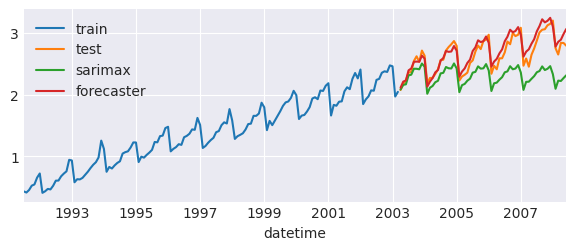

In [ ]:
# Compare predictions with an arima (lags, 1, 0)
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
steps = len(data.loc[end_train:])

sarimax = SARIMAX(data.loc[:end_train], order=(12, 1, 0))
res_sarimax = sarimax.fit(disp=False, maxiter=1000)
predictions_sarimax = res_sarimax.get_forecast(steps).predicted_mean
print("Predictions Sarimax")
display(predictions_sarimax.head(4))

forecaster = ForecasterAutoreg(
                 regressor       = LinearRegression(),
                 lags            = 12,
                 differentiation = 1
            )
            
forecaster.fit(y=data.loc[:end_train])
print("Predictions Forecaster")
predictions = forecaster.predict(steps=steps)
display(predictions.head(4))

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_sarimax.plot(ax=ax, label='sarimax')
predictions.plot(ax=ax, label='forecaster')
ax.legend();